# Exercise 3

이번 숙제는 
1. **Multi-class Logistic Regresions**
2. **Neural Network Forward Propagation**

으로 구성되어있다.

데이터파일은 아래와 같이 주어져 있음.
* **ex3data1.mat**
    * X (5000, 400) -- 5,000개의 20 x 20 숫자 이미지
    * y (5000, 1) -- 5,000개에 대한 Correct Class

* **ex3weights.mat** -- 이거는 Neural Network 에 사용할 데이터
    * Theta1 (25, 401) 
    * Theta2 (10, 26)


## 필요한 라이브러리 호출

In [1]:
import numpy as np
from scipy.io import loadmat # mat 파일을 읽는데 필요하다.
from scipy.optimize import fmin_cg # octave에서 사용한 minimize function
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def 그림을그려보자(X_i):
    plt.imshow(X_i.reshape(20, 20).T, cmap="Greys")
    plt.axis('off')

## 데이터 불러오기

In [3]:
data1 = loadmat(file_name="./ex3data1.mat")
data2 = loadmat(file_name="./ex3weights.mat")

X = data1['X']
y = data1['y']

Theta1 = data2['Theta1']
Theta2 = data2['Theta2']
del data1, data2

In [4]:
STMT = """
X.shape: {}
y.shape: {}

Theta1.shape {}
Theta2.shape {}
""".format(X.shape, y.shape, Theta1.shape, Theta2.shape)
print(STMT)


X.shape: (5000, 400)
y.shape: (5000, 1)

Theta1.shape (25, 401)
Theta2.shape (10, 26)



## 데이터 살펴보기

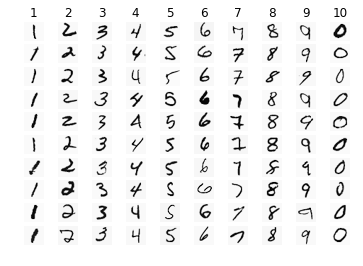

In [5]:
i = 1
for row in range(10): # y에는 1 ~ 10 까지 고유한 숫자가 존재
    for num in np.unique(y):        
        plt.subplot(10, 10, i)
        if i <= 10:
            plt.title("{}".format(num))
        sample = X[(y == num).flatten()]
        choice = np.random.randint(low=0, high=sample.shape[0])
        #plt.imshow(sample[choice, :].reshape(20, 20).T, cmap='Greys')
        그림을그려보자(sample[choice, :])
        i += 1
       
plt.show()

#### 결론: class 10은 0을 의미하네?

## 필요 함수 정의

### 숙제에는 없지만 귀찮아서 헬퍼 펑션 만듬

In [6]:
def bias_trick(X):
    """bias term X_0을 추가해준다. 귀찮아서 만듬.
    이 정도는 이제 눈감고 만들 수 있어야 된다.
    """
    return np.append(np.ones(shape=(X.shape[0],1)), X, axis=1)

sigmoid = lambda x: 1 / (1 + np.exp(-x)) # sigmoid

def get_accuracy(y_pred, y_real):
    STMT = """
정확도: {:.2%}     
    """.format(np.mean(y_pred.reshape(-1, 1) == y_real.reshape(-1, 1)))
    print(STMT)

# 1. Multi-class Logistics Regression 시작

In [7]:
def lr_cost_function(theta, X, y, l=0.1):
    """Cost J를 리턴하는 함수
    
    Parameters
    ================================================
    theta : 세타 (D+1, 1) -- Bias Term 이 추가 되서 D+1
    X     : 엑스 (N, D+1) -- Bias Term 이 추가 되서 D+1
    y     : 와이 (N, 1)
    l     : 람다 for regularization (default=0.1)
    
    Returns
    ================================================
    J     : cost (float)
    """
    y = y.reshape(-1, 1) # 혹시 몰라서 해줌.
    theta = theta.reshape(-1, 1) # 혹시 몰라서 해줌
    
    m = X.shape[0] # Sample 수
    
    z = X.dot(theta)
    h = sigmoid(z)
    J_i = -y * np.log(h) - (1 - y) * np.log(1 - h)
    J = np.sum(J_i) / m + np.sum(np.square(theta[1:, :])) * l / (2 * m)
    
    return J

def lr_grad_function(theta, X, y, l=0.1):
    """위 함수와 같지만 Gradient Descent (dTheta)를 돌려준다.
    이렇게 함수를 나누는 이유는 최적화 알고리즘 라이브러리 fmin_cg를 사용하기 때문이다.
    
    Parameters
    ===============
    위와 동일
    
    Returns
    ===============
    grad  : dTheta임으로 dTheta와 같은 (D, 1) 사이즈지만 라이브러리 사용을 위해 (D,) 형태로 Flatten 해준다.
    """
    y = y.reshape(-1, 1) # Just in case..
    theta = theta.reshape(-1, 1) # same..
    
    m = X.shape[0]
    
    z = X.dot(theta)
    h = sigmoid(z)
    
    temp = theta
    temp[0] = 0
    
    err = (h - y).reshape(-1, 1)
    grad = X.T.dot(err) / m + temp.reshape(-1, 1) * l / m
    
    return grad.flatten()

## 이제 Gradient Descent를 통해 최적화를 하는 함수를 만든다

In [8]:
def one_vs_all(X, y, num_labels, l):
    """숙제에서 Loss를 최소화하는 Theta를 찾아준다
    방법은 각각의 클래스에 대해서 Forloop으로 Logistic Regression을 돌린다.
    
    Parameters
    ====================
    X          : 여기서는 Bias Term을 밑에서 추가하기 때문에 (N, D) 이다.
    y          : (N, 1)
    num_labels : 위에서 숫자가 10개 있는걸 확인했으니 10이다
    l          : 0.1 hyper parameter regularization에 사용됨
    
    Returns
    =====================
    all_theta : (num_labels, D+1) Multiclass Loss를 최소화하는 Theta값을 돌려준다.
    """
    X = bias_trick(X) # 이걸 위해 위에서 만들었다.
    all_theta = np.zeros(shape=(num_labels, X.shape[1]))
    for i in range(num_labels):
        init_theta = np.random.randn(X.shape[1], 1) + 1e-7 # 각 클래스에 대한 theta 초기값이다.
        best_theta = fmin_cg(lr_cost_function, init_theta, fprime=lr_grad_function, args=(X, (y==i+1)*1, l) ,disp=0) 
        # 최적화 CG 알고리즘 사용// Args 값에 주의하자. True * 1 = 1이다.
        
        all_theta[i, :] = best_theta.flatten() # 찾은 Theta를 올 쎄타에 저장한다.
        
    return all_theta

In [9]:
def predict_one_vs_all(all_theta, X):
    '''앞에서 찾은 Best Theta로 값을 예측한다.
    
    Parameters
    ===============
    X  :  (N, D) 밑에서 Bias Trick을 사용할 것이기 때문에 D
    
    Returns
    ===============
    y  :  (N, 1) 각각 샘플에 대한 예측값
    
    '''
    X = bias_trick(X)
    
    z = X.dot(all_theta.T) # 이런 식은 손으로 풀어보시구
    h = sigmoid(z)         # 
    
    max_indices = np.argmax(h, axis=1) # argmax를 사용하면 max의 인덱스값을 알려준다. axis=1은 각 행 별로 max의 위치를 return한다. 
    p = max_indices + 1 # 0-9까지 있는걸 1-10까지 바꿔줘야 y랑 비교가 가능하다.
    
    return p

## 이제 실행해보자

In [10]:
all_theta = one_vs_all(X, y, num_labels=10, l=0.1)
y_pred = predict_one_vs_all(all_theta, X)
get_accuracy(y_pred, y)


정확도: 96.46%     
    


### 실제 숙제에서 94.9%가 나오는데 Octave보다 잘나왔다.

그럼 기존 라이브러리랑도 비교해보자

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
lr = LogisticRegression()
lr.fit(X, y.flatten())
y_pred = lr.predict(X)
get_accuracy(y_pred, y)


정확도: 94.38%     
    


## ?? 기존 라이브러리보다 잘나오지만 Train Set이라 별 의미가 없음
### 잘되고 있는것 같다

실제값: 4, 예측값: 4


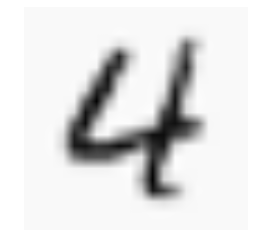

In [13]:
i = np.random.choice(range(y.shape[0]))
y_pred = predict_one_vs_all(all_theta, X[i:i+1, :])
print("실제값: {}, 예측값: {}".format(y[i][0], y_pred.flatten()[0]))
그림을그려보자(X[i:i+1])
plt.show()

# 2. Neural Network 시작

아직 Back Propagation에 대해 배우지 않았기 때문에 Forward Propagation만 하면 된다. 그래서 Theta1, Theta2가 주어져 있음.

In [14]:
def predict(Theta1, Theta2, X):
    X = bias_trick(X)
    h1 = sigmoid(X.dot(Theta1.T))
    
    X_next = bias_trick(h1)            # 이 식들이 왜 이런지는 손으로 풀어보세요.
    h2 = sigmoid(X_next.dot(Theta2.T)) # Layer 지나갈때마다 같은 패턴이다. Tensorflow의 핵심
    
    idx = np.argmax(h2, axis=1)
    p = idx + 1
    
    return p

## Neural Network의 성능을 알아보자. Logistic Regression보다는 높아야 된다.

In [15]:
y_pred = predict(Theta1, Theta2, X)
get_accuracy(y_pred, y)


정확도: 97.52%     
    


# 정확도 94프로에서 98프로 가까이 올랐다.
이것으로 숙제를 마침